# BMS 353 Bioinformatics Project

**Gi Shuen Kirsty Lee**

This project investigates the role of a transcription factor, SP1, in colon cells. The data being analysed will be from cell cultures 48 hours after SP1 was silenced, and control cells where it was not silenced. There are two samples in each condition, and the gene expression profiles were quantified using Affymetrix GeneChip HGU133 PLUS 2. 

The pipeline for the analysis of this project is as follows:

1. Load data and convert to affymetrix
2. Pre-process data with RMA to normalize data
    - Visualise data with MA plots and box plot
3. Analyse differential gene expression with Puma
    - Visualise data with MA plots and box plots
    - Extract the top differentially expressed genes
    - Annotate probeset with gene names and symbols
4. Principal component analysis
5. Hierarchical clustering with a heatmap
6. Functional pathway analysis with PANTHER

**1. Loading data**

In [2]:
options(jupyter.plot_mimetypes ='image/png')

This line of code was executed so as to make sure output plots are executed as PNG files, which are small in size - to keep the file size of this notebook small.

The affy package is then loaded, and the working directory set, in order to be able to load the data and convert it into an Affybatch Object for pre-processing.

In [3]:
library(affy)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To c

In [4]:
setwd("~/Autumn2015/Week12_cAt/data_groupA/")
getwd()

[1] "/projects/20138cfe-1ee5-4c4b-ad6d-60908cc27d7e/Autumn2015/Week12_cAt/data_groupA"

Data is now loaded into an AffyBatch object, sp1.

In [5]:
sp1_filenames <- c("M48-1.CEL", "M48-2.CEL", "S48-1.CEL", "S48-2.CEL")
sp1 <- ReadAffy(filenames=sp1_filenames)

In [6]:
sp1

Warning message:
: replacing previous import by ‘utils::tail’ when loading ‘hgu133plus2cdf’Warning message:
: replacing previous import by ‘utils::head’ when loading ‘hgu133plus2cdf’


AffyBatch object
size of arrays=1164x1164 features (18 kb)
cdf=HG-U133_Plus_2 (54675 affyids)
number of samples=4
number of genes=54675
annotation=hgu133plus2
notes=

Now that the data is loaded in an Affybatch Object, sp1, the data will be pre-processed using rma to normalize the data. The results will be extracted from an expression set into an object, eset_rma.

**2. Pre-processing data**

In [7]:
library(affy)
sp1_rma <- affy::rma(sp1)
sp1_rma

Background correcting
Normalizing
Calculating Expression


ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 4 samples 
  element names: exprs 
protocolData
  sampleNames: M48-1.CEL M48-2.CEL S48-1.CEL S48-2.CEL
  varLabels: ScanDate
  varMetadata: labelDescription
phenoData
  sampleNames: M48-1.CEL M48-2.CEL S48-1.CEL S48-2.CEL
  varLabels: sample
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation: hgu133plus2 

In [8]:
eset_rma <- exprs(sp1_rma)

This pre-processed data will now be visualized with a boxplot, and MA plot to make sure that the data is normalized. 

In [9]:
library(puma)
library(affy)
library(limma)

Loading required package: oligo
Loading required package: oligoClasses
Welcome to oligoClasses version 1.32.0

Attaching package: ‘oligoClasses’

The following object is masked from ‘package:affy’:

    list.celfiles

Loading required package: Biostrings
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges
Loading required package: XVector
Welcome to oligo version 1.34.0

Attaching package: ‘oligo’

The following objects are masked from ‘package:affy’:

    intensity, MAplot, mm, mm<-, mmindex, pm, pm<-, pmindex,
    probeNames, rma

Loading required package: mclust
Package 'mclust' version 5.1
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘limma’

The following object is masked from ‘package:oligo’:

    backgroundCorrect

The following object is masked from ‘package:BiocGenerics’:

    plotMA



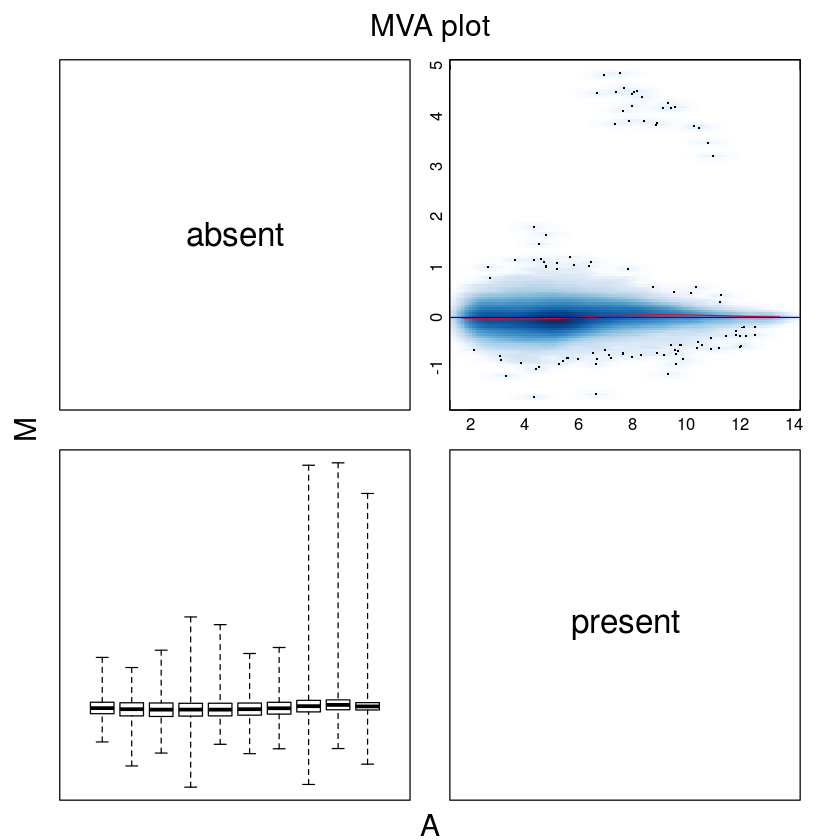

In [10]:
groups<-c("absent","present")
table_rma<-data.frame(sampleNames(sp1_rma),groups)
group10hr <- factor(groups[1:4])
MAplot(sp1_rma[,1:4], pairs=TRUE, groups=group10hr)

This MA plot allows us to visualize that the data has been normalized by RMA pre-processing, as a flat relationship can be observed between the ratio of signal between two arrays and signal level. 

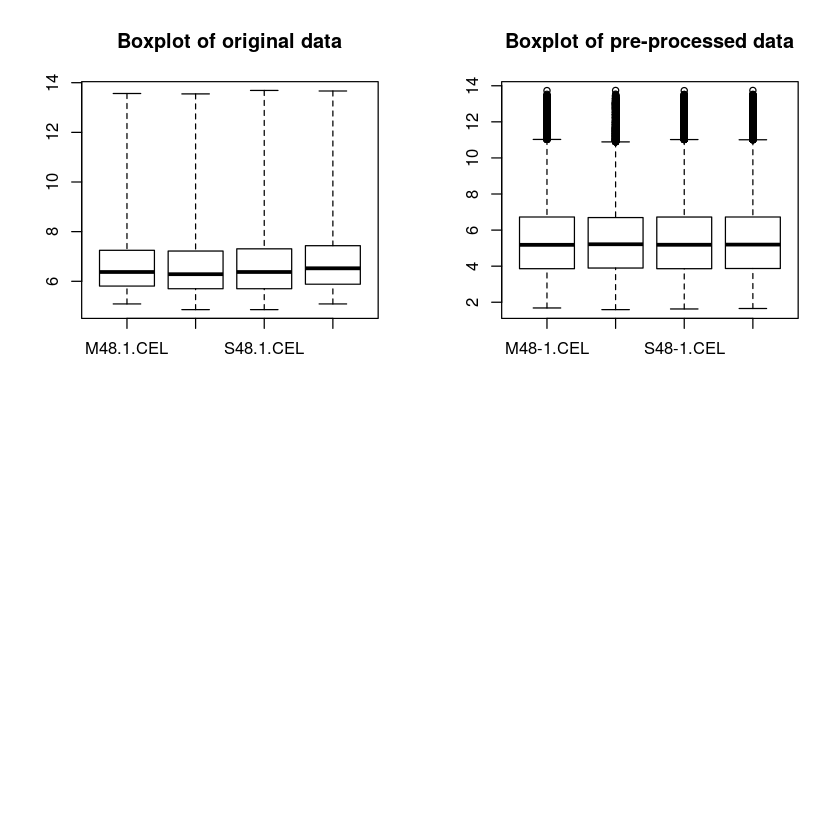

In [11]:
par(mfrow=c(2,2))
boxplot(sp1, main="Boxplot of original data")
boxplot(eset_rma, main="Boxplot of pre-processed data")

The comparison of the boxplots before and after RMA pre-processing further confirms that the data has been normalized - as it can be seen that the mean of the distributions are the same and are centered.

**3. Differential expression analysis with Puma**

The puma package will now be loaded so as to be able to perform differential expression analysis of the genes.

In [12]:
library(puma)

Phenodata for the dataframe was annotated so that the data can be combined with pumaCombImproved after expression levels of genes are estimated with the mmgmos package in puma.

In [13]:
pData (sp1) <- data.frame("SP1.Silencing"=c("absent", "absent", "present", "present"), row.names=rownames(pData(sp1)))
pData(sp1)

SP1.Silencing
M48-1.CEL        absent
M48-2.CEL        absent
S48-1.CEL       present
S48-2.CEL       present

The data was then processed with the mmgmos package in puma to estimate the expression levels of the genes.

In [14]:
sp1_puma <- mmgmos(sp1)
sp1_puma

Model optimising ..............................................................................................................
Expression values calculating ..............................................................................................................
Done.


Expression Set (exprReslt) with 
	54675 genes
	4 samples
	An object of class 'AnnotatedDataFrame'
  sampleNames: M48-1.CEL M48-2.CEL S48-1.CEL S48-2.CEL
  varLabels: SP1.Silencing
  varMetadata: labelDescription

In [15]:
eset_puma <- exprs(sp1_puma)

This analysis by puma's mmgmos function was then visualized as an MA plot and a boxplot, seen below.

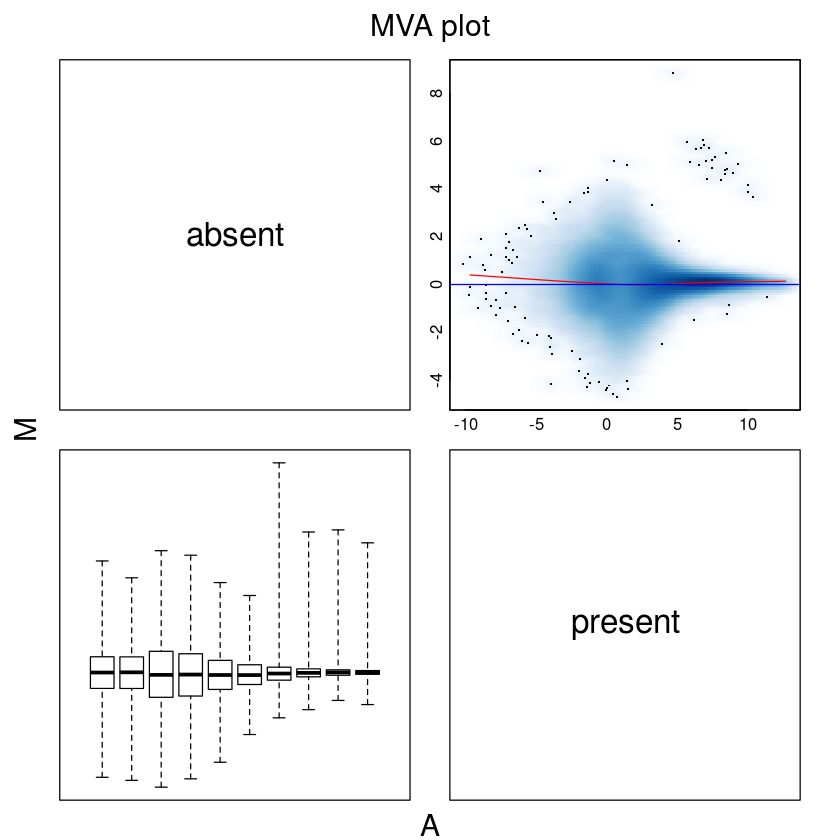

In [16]:
groups<-c("absent","present")
table_puma<-data.frame(sampleNames(sp1_puma),groups)
group10hr <- factor(groups[1:2])
MAplot(sp1_puma[,1:2], pairs=TRUE, groups=group10hr)

This MA plot allows us to see that the outliers of the data have been removed, and that the difference between the two conditions is symmetrical, and the spread is mostly centered around the mean.

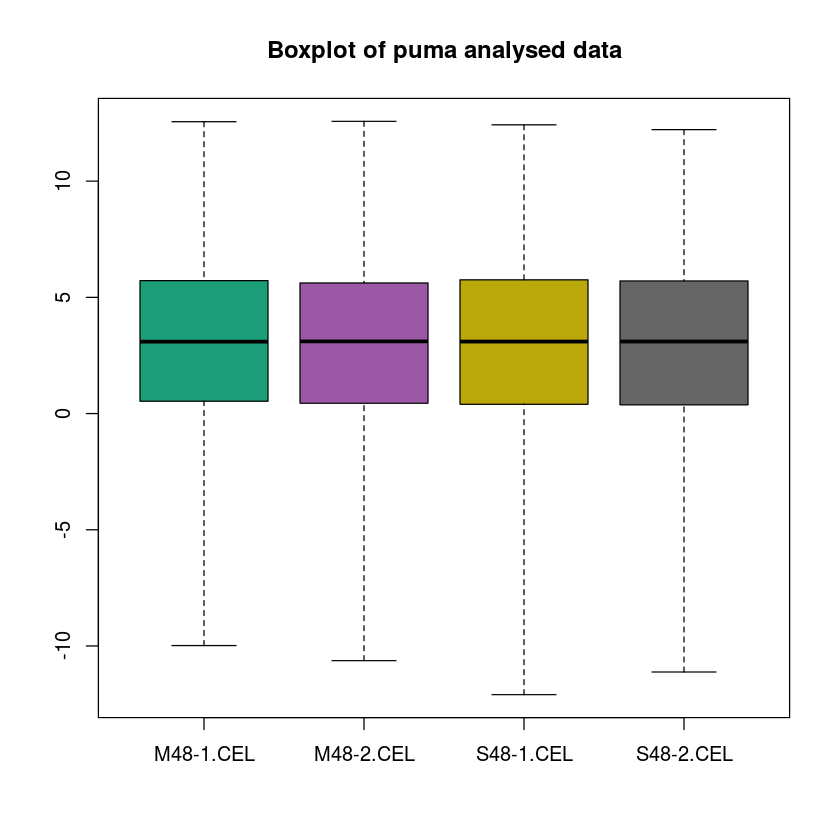

In [17]:
boxplot(sp1_puma, main="Boxplot of puma analysed data")

From the boxplot, it can be observed that the data is already normalized and does not need any further normalisation. However it can be seen that there is variation outside of the upper and lower quartiles of the data. As the outliers have been removed, it can be seen that the means have decreased in value slightly, when comparing with the boxplot of the original data shown earlier.

The data was then combined with pumaCombImproved so as to be able to perform differential expression analysis. This combining was done using a bayesian Hierarchical model in puma. Due to the long processing time that this took, the code was executed and saved to a file, sp1_comb.RDA, which is seen to be loaded in the following cell.

The code that was used to combine the data is as follows:

``` sp1_comb <- pumaCombImproved(sp1_puma)
save(sp1_comb, file="sp1_comb.RDA")```

In [18]:
load(file="sp1_comb.RDA")

In [19]:
sp1_comb

ExpressionSet (storageMode: lockedEnvironment)
assayData: 54675 features, 2 samples 
  element names: exprs, se.exprs 
protocolData: none
phenoData
  sampleNames: absent present
  varLabels: SP1.Silencing
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [20]:
eset_comb <- exprs(sp1_comb)

Differential expression analysis was then carried out using the puma package, and results written into a .csv file. This allows us to compare relative gene expression between the control and silenced cell conditions, in order to see which genes are affected the most by the silencing of SP1.

In [21]:
pumaDEres <- pumaDE(sp1_comb)
write.reslts(pumaDEres, file="pumaDEres")

In [22]:
pumaDEresults <- read.csv(file="pumaDEres_statistics.csv")

In [65]:
pumaFC <- read.csv(file="pumaDEres_FCs.csv")

The P-like value of the results from pumaDE was also calculated, and visualized as a histogram.

In [23]:
puma_plv <- pLikeValues(pumaDEres, contrast=1, direction="either")

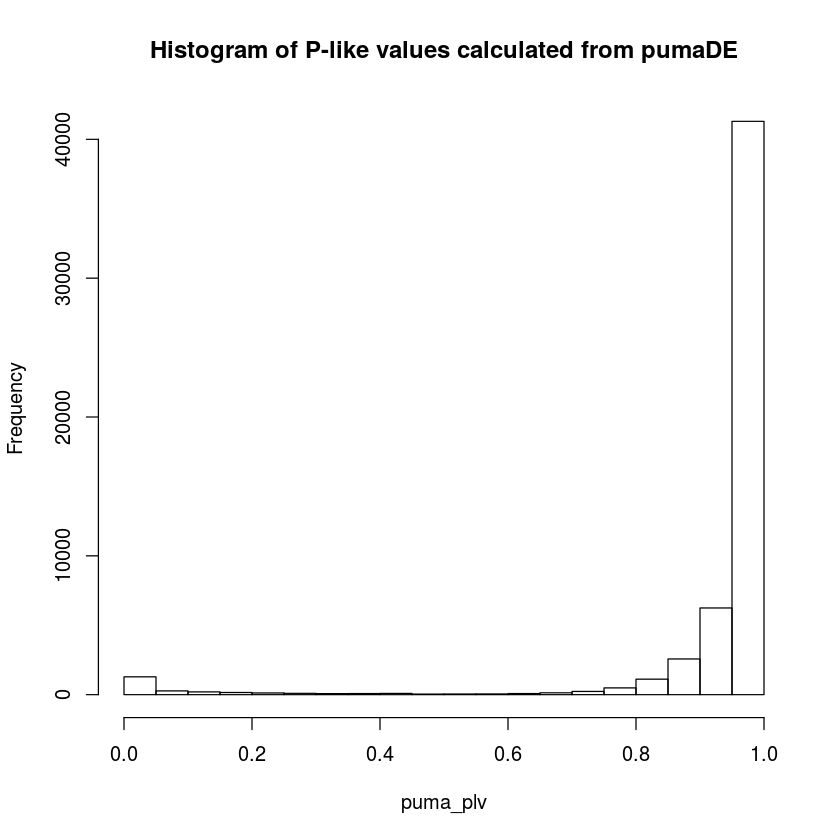

In [24]:
hist(puma_plv, main="Histogram of P-like values calculated from pumaDE")

P-like values range between 0 and 1, where 0 has the highest probability of being differentially expressed, and 1 the lowest. From this histogram, it can be seen that a large majority of the genes were likely not differentially expressed, and there is a small set, of frequency roughly 100-200 that have a high probability of being differentially expressed. 

The top differentially expressed genes were then extracted using >1 and <-1 for cut off values in fold change, and PPLR cut off values of >0.99 and <0.01 to compare different methods of extracting the top differentially expressed genes.

In [66]:
topFC1 <- pumaFC[which(pumaFC$present_vs_absent< -1),]

In [67]:
topFC2 <- pumaFC[which(pumaFC$present_vs_absent>1),]

In [68]:
topFC <- merge(topFC1, topFC2, all=TRUE)

In [71]:
length(topFC$present_vs_absent)

[1] 261

It can be seen that 261 genes were found to be the genes most likely to be affected by the the silencing of SP1.

In [25]:
pumaDEresultsX <- as.character(pumaDEresults$X)

The top differentially expressed genes are now to be extracted using the PPLR values, and merged into a dataset called topgenes.

In [26]:
topgenes1 <- pumaDEresults[which(pumaDEresults$present_vs_absent>0.99),]

In [27]:
topgenes2 <- pumaDEresults[which(pumaDEresults$present_vs_absent<0.01),]

In [28]:
topgenes <- merge(topgenes1, topgenes2, all=TRUE)

In [29]:
length(topgenes$X)

[1] 990

It can be seen that the two ways of extracting the genes most affected by the silencing of SP1 differ in their stringency, and using the fold change is a much stricter method. To be on the conservative side, the genes extracted by their PPLR value will be used.


Topgenes, containing the probesets, was then annotated with the symbol, gene name, and probe ID - annotated_list, and the NAs present omitted. The final list of genes that display the most change between conditions is loaded under the name 'annotated_list_na'.

In [30]:
library(annotate)
library(hgu133plus2.db)

Loading required package: AnnotationDbi
Loading required package: XML
Loading required package: org.Hs.eg.db
Loading required package: DBI




In [31]:
geneProbes <- (as.character(topgenes$X))
annotated_list <- select(hgu133plus2.db, geneProbes, c("SYMBOL", "GENENAME"), "PROBEID")

'select()' returned 1:many mapping between keys and columns


In [32]:
annotated_list

PROBEID        SYMBOL
1      1552580_at        TRIML2
2    1552658_a_at          NAV3
3      1553142_at         LACC1
4    1553292_s_at        SGK494
5    1553402_a_at           HFE
6      1553546_at          <NA>
7    1553679_s_at      VKORC1L1
8    1553685_s_at           SP1
9    1554352_s_at       DENND4A
10   1554471_a_at      ANKRD13C
11   1554883_a_at         ERCC8
12     1555673_at      KRTAP2-3
13     1555673_at      KRTAP2-4
14     1555888_at      UBR5-AS1
15   1555889_a_at         CRTAP
16   1556285_s_at          PPA2
17   1556499_s_at        COL1A1
18   1556696_s_at     NR2F1-AS1
19   1556769_a_at  LOC105371967
20   1557238_s_at          <NA>
21   1557411_s_at      SLC25A43
22     1557487_at          <NA>
23     1557805_at          <NA>
24     1558111_at         MBNL1
25     1558522_at          MPP6
26     1558605_at          <NA>
27   1558606_s_at          TTC5
28     1558871_at  LOC105377276
29   1558906_a_at     OSER1-AS1
30     1558930_at     LINC00460
⋮               ⋮             ⋮
1009    242317_at        HIGD1A
1010    242473_at         TRAF4
1011  242474_s_at         VMA21
1012    242509_at          <NA>
1013    242577_at     LOC389834
1014    242584_at       FAM161A
1015    242629_at         RAB3B
1016    242794_at         MAML3
1017    242909_at          <NA>
1018    243010_at          MSI2
1019    243031_at          <NA>
1020  243110_x_at           NPW
1021    243582_at        SH3RF2
1022    243610_at      C9orf135
1023    244163_at        SEMA3A
1024    244187_at          <NA>
1025    244563_at         QSER1
1026    244764_at        HIVEP3
1027    244829_at     LINC00518
1028     32088_at         BLZF1
1029     34408_at          RTN2
1030     34764_at         LARS2
1031     38892_at      GLTSCR1L
1032     50221_at          TFEB
1033     53720_at      C19orf66
1034     58916_at        KCTD14
1035     58916_at NDUFC2-KCTD14
1036     59705_at          SCLY
1037     65472_at       C2orf68
1038     91826_at        EPS8L1
                                                                                   GENENAME
1                                                            tripartite motif family-like 2
2                                                                        neuron navigator 3
3                                  laccase (multicopper oxidoreductase) domain containing 1
4                                    uncharacterized serine/threonine-protein kinase SgK494
5                                                                           hemochromatosis
6                                                                                      <NA>
7                                     vitamin K epoxide reductase complex, subunit 1-like 1
8                                                                  Sp1 transcription factor
9                                                            DENN/MADD domain containing 4A
10                                                                ankyrin repeat domain 13C
11                                            excision repair cross-complementation group 8
12                                                           keratin associated protein 2-3
13                                                           keratin associated protein 2-4
14                                                                     UBR5 antisense RNA 1
15                                                             cartilage associated protein
16                                                            pyrophosphatase (inorganic) 2
17                                                                collagen, type I, alpha 1
18                                                                    NR2F1 antisense RNA 1
19                                                             uncharacterized LOC105371967
20                                                                                     <NA>
21                                                      solute carrier family 25, member 43
22

In [33]:
length(annotated_list$GENENAME)

[1] 1038

In [34]:
annotated_list_na<- na.omit(annotated_list)
length(annotated_list_na$GENENAME)
annotated_list_na

[1] 998

PROBEID        SYMBOL
1      1552580_at        TRIML2
2    1552658_a_at          NAV3
3      1553142_at         LACC1
4    1553292_s_at        SGK494
5    1553402_a_at           HFE
7    1553679_s_at      VKORC1L1
8    1553685_s_at           SP1
9    1554352_s_at       DENND4A
10   1554471_a_at      ANKRD13C
11   1554883_a_at         ERCC8
12     1555673_at      KRTAP2-3
13     1555673_at      KRTAP2-4
14     1555888_at      UBR5-AS1
15   1555889_a_at         CRTAP
16   1556285_s_at          PPA2
17   1556499_s_at        COL1A1
18   1556696_s_at     NR2F1-AS1
19   1556769_a_at  LOC105371967
21   1557411_s_at      SLC25A43
24     1558111_at         MBNL1
25     1558522_at          MPP6
27   1558606_s_at          TTC5
28     1558871_at  LOC105377276
29   1558906_a_at     OSER1-AS1
30     1558930_at     LINC00460
31     1559739_at         CHPT1
32   1559822_s_at          MTDH
34   1561347_a_at  LOC101927166
35     1562019_at        NT5DC4
36   1562738_a_at      USP3-AS1
⋮               ⋮             ⋮
1003    241959_at       ANAPC10
1004    242005_at     LINC00973
1006    242146_at        SNRPA1
1007    242149_at       FAM210A
1009    242317_at        HIGD1A
1010    242473_at         TRAF4
1011  242474_s_at         VMA21
1013    242577_at     LOC389834
1014    242584_at       FAM161A
1015    242629_at         RAB3B
1016    242794_at         MAML3
1018    243010_at          MSI2
1020  243110_x_at           NPW
1021    243582_at        SH3RF2
1022    243610_at      C9orf135
1023    244163_at        SEMA3A
1025    244563_at         QSER1
1026    244764_at        HIVEP3
1027    244829_at     LINC00518
1028     32088_at         BLZF1
1029     34408_at          RTN2
1030     34764_at         LARS2
1031     38892_at      GLTSCR1L
1032     50221_at          TFEB
1033     53720_at      C19orf66
1034     58916_at        KCTD14
1035     58916_at NDUFC2-KCTD14
1036     59705_at          SCLY
1037     65472_at       C2orf68
1038     91826_at        EPS8L1
                                                                                   GENENAME
1                                                            tripartite motif family-like 2
2                                                                        neuron navigator 3
3                                  laccase (multicopper oxidoreductase) domain containing 1
4                                    uncharacterized serine/threonine-protein kinase SgK494
5                                                                           hemochromatosis
7                                     vitamin K epoxide reductase complex, subunit 1-like 1
8                                                                  Sp1 transcription factor
9                                                            DENN/MADD domain containing 4A
10                                                                ankyrin repeat domain 13C
11                                            excision repair cross-complementation group 8
12                                                           keratin associated protein 2-3
13                                                           keratin associated protein 2-4
14                                                                     UBR5 antisense RNA 1
15                                                             cartilage associated protein
16                                                            pyrophosphatase (inorganic) 2
17                                                                collagen, type I, alpha 1
18                                                                    NR2F1 antisense RNA 1
19                                                             uncharacterized LOC105371967
21                                                      solute carrier family 25, member 43
24                                                    muscleblind-like splicing regulator 1
25                         membrane protein, palmitoylated 6 (MAGUK p55 subfamily member 6)
27

In [35]:
symbol<- annotated_list_na$SYMBOL

Principle Components Analysis was then carried out on the puma analysed data to visualise the variation between the conditions.

**4. Principal Component Analysis**

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14


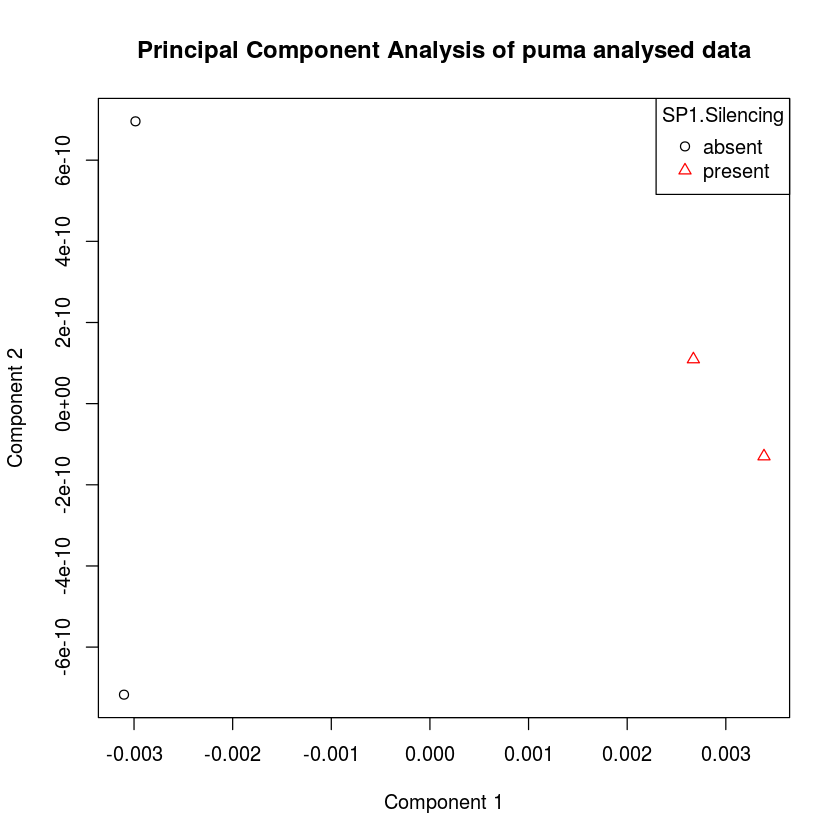

In [36]:
pumapca_sp1<-pumaPCA(sp1_puma)
plot(pumapca_sp1, main="Principal Component Analysis of puma analysed data")

PCA allows for the data to be separated into unrelated dimensions, allowing for the data to be visualized without being affected by the other factors. From this PCA plot it can be seen that the two conditions where SP1 was silenced (red triangles) have a large variance in relation to the control conditions - silencing of SP1 affected gene transcription of a large number of genes.

** 5. Hierarchical Clustering**

In [37]:
library(gplots)


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:stats’:

    lowess



Hierarchical clustering was then performed, with the output being a heatmap - seen below. Heatmaps allow for gene expression levels to be visualized across a number of samples or conditions, allowing for comparison across conditions. 

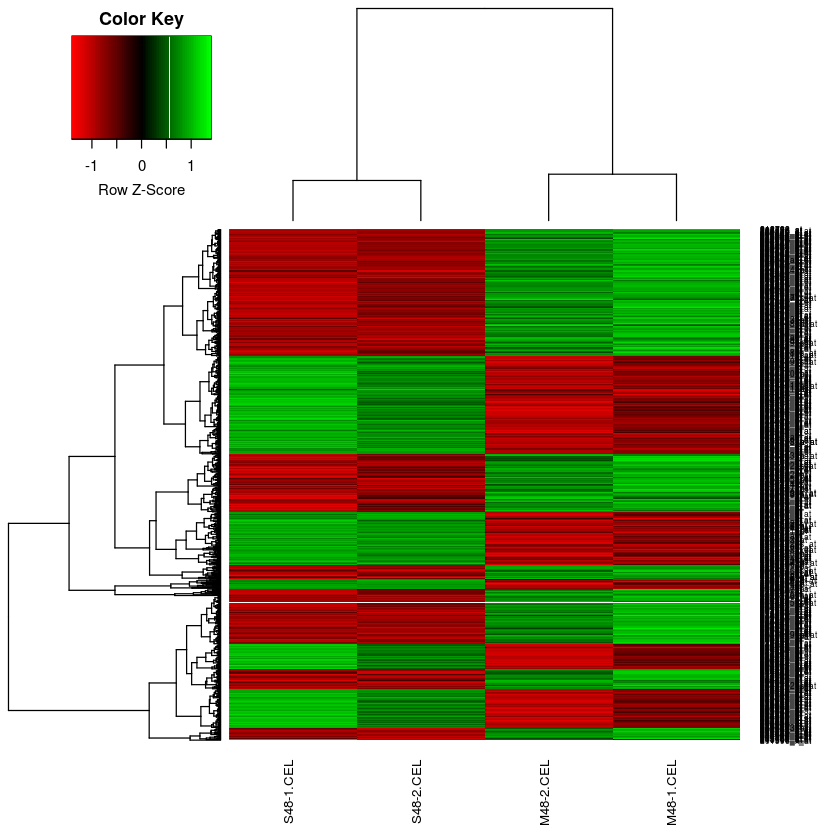

In [38]:
# find the IDs that belong to the DE genes.
tID<-topgenes$X
ind<-1
j<-1
for (i in 1: length(tID)) {
	ind[j]<-which(rownames(sp1_puma)==tID[i],arr.ind=TRUE)
	j<-j+1
}

# ind is the vector with all the indexes
topExpr<-exprs(sp1_puma)[ind,]
heatmap.2(topExpr, col=redgreen(75), scale="row",
key=TRUE, symkey=FALSE, density.info="none", trace="none", cexRow=0.5, cexCol=0.8)

It can be clearly observed from the heatmap generated that there is a clear difference in gene expression between the silenced cells and control cells. Genes that are seen to be downregulated in the control conditions are seen to be upregulated, and vice versa. A comparison of M48.2 and S48.2 (Sample 2 of Control and Silenced cells) reveals that the colours on the heatmap are completely opposite of each other (red becomes green, and vice versa) - allowing the inference that after silencing of SP1, the effects on gene transcription were reversed. 

**6. Functional pathway analysis with PANTHER**

In [39]:
write(symbol, file="symbols.tsv")

The data in the Symbols column of the annotated list of top differentially expressed genes was saved, and inputted to the Panther database in order to investigate which pathways were involved. The list of pathways generated by the Panther database was saved and has been loaded below, under the dataframe 'genepathways'.

In [40]:
panther <- read.table("pantherGeneList.txt", sep="\t")

In [41]:
genepathways <- as.data.frame(panther$V3)

In [42]:
print(genepathways)

                                                                          panther$V3
1                                                       p53 pathway feedback loops 2
2                                  Metabotropic glutamate receptor group III pathway
3                                                       Opioid proenkephalin pathway
4                                                              Arginine biosynthesis
5                                                Axon guidance mediated by Slit/Robo
6                                                              Vitamin B6 metabolism
7                                                 Opioid proopiomelanocortin pathway
8                                                        Apoptosis signaling pathway
9                                      5HT1 type receptor mediated signaling pathway
10                                                            VEGF signaling pathway
11                                                             FG

The symbols inputted into Panther were also available for visualisation as a pie chart depending on the ontology. The pie charts for the biological process ontology and molecular function ontology can be seen below.



**Pie chart showing the biological process ontology of the top differentially expressed genes 48 hours after SP1 silencing**

![Pie chart showing the biological process ontology of the top differentially expressed genes](images/panther_bioprocess.png)

It can be seen from this pie chart that majority of the genes that have been altered by the silencing of SP1 are largely related to metabolic or cellular processes in the cell, and to a lesser extent, biological regulation, developmental processes and localisation. As SP1 is a transcription factor that binds DNA, this is unsurprising - Tan and Khachigian (2009) have reported that it regulates the expression of a multitude of genes that control cellular processes.


**Pie chart showing the molecular function ontology of the top differentially expressed genes 48 hours after SP1 silencing**

![Pie chart showing the molecular function ontology of the top differentially expressed genes](images/panther_molfunction.png)

From this pie chart, it is observed that majority of the genes are associated with binding and catalytic activity in the cell, which is unsurprising as SP1 is a transcription factor, and would therefore be associated with a number of binding factors and enzymatic reactions in the cell.

**Conclusion**

From the analysis of the results obtained from the AffyBatch GeneChip, it can be concluded that SP1 has a large effect on gene transcription in the colon cell. Up to 99 pathways are affected - seen in the 'genepathways' dataframe; majority of which are common signalling pathways seen in most cells, such as the p53 pathway, Wnt signalling pathway, and TGF beta signalling pathway. The genes changing the most between the two conditions can be observed through the dataset 'topgenes'. Through the analysis of the top differentially expressed genes, it was found that majority of the genes affected were related to metabolic and cellular processes in the cell, and their molecular function were associated to binding and catalytic activity. This is expected as SP1 being a transcription factor would likely be associated with cellular and metabolic activity, which would require catalytic reactions. Silencing of SP1 resulted in the genes being either upregulated or downregulated, opposite to what they would have been in a control condition. 